In [ ]:
!pip install -qq transformers[sentencepiece]
!pip install -qq ohmeow-blurr
!pip install  -qq fastai --upgrade 
!pip install -qq datasets

     |████████████████████████████████| 3.4 MB 7.0 MB/s 
     |████████████████████████████████| 596 kB 72.8 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 895 kB 86.5 MB/s 
     |████████████████████████████████| 3.3 MB 82.8 MB/s 
     |████████████████████████████████| 1.2 MB 72.6 MB/s 
     |████████████████████████████████| 91 kB 5.7 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
     |████████████████████████████████| 306 kB 44.4 MB/s 
     |████████████████████████████████| 189 kB 67.3 MB/s 
     |████████████████████████████████| 56 kB 6.2 MB/s 
     |████████████████████████████████| 243 kB 71.1 MB/s 
     |████████████████████████████████| 133 kB 66.5 MB/s 
     |████████████████████████████████| 1.1 MB 69.4 MB/s 
     |████████████████████████████████| 271 kB 97.7 MB/s 
     |████████████████████████████████| 160 kB 91.4 MB/s 
     |████████████████████████████████| 144 kB 98.3 MB/s 


#Import 

In [ ]:
import ast, inspect, torch
from typing import Any, Callable, Dict, List, Optional, Union, Type

from datasets import load_metric as hf_load_metric, list_metrics as hf_list_metrics
from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, ranger, OptimWrapper, params
from fastai.torch_core import *
from fastai.torch_imports import *
from fastai.text.all import *
from fastprogress.fastprogress import progress_bar,master_bar
from transformers import (
    AutoModelForSeq2SeqLM, logging,
    PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel
)

from blurr.utils import BLURR
from blurr.data.seq2seq.core import HF_Seq2SeqBlock, HF_Seq2SeqBeforeBatchTransform, default_text_gen_kwargs
from blurr.modeling.core import HF_BaseModelWrapper, HF_BaseModelCallback, HF_PreCalculatedLoss, Blearner
from blurr.modeling.seq2seq.core import HF_Seq2SeqMetricsCallback, seq2seq_splitter

logging.set_verbosity_error()

In [ ]:
import os, ast, inspect, pdb
from functools import reduce

from datasets import list_datasets, load_dataset
from fastai.data.external import untar_data, URLs
from fastcore.test import *
from transformers import MBartForConditionalGeneration

from blurr.utils import print_versions

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print_versions('torch fastai transformers')

torch: 1.10.0+cu111
fastai: 2.5.3
transformers: 4.15.0


#Dataset

In [ ]:
!wget 'https://github.com/ThanhChinhBK/vietnews/archive/master.zip'
!unzip 'master.zip'

In [ ]:
def listPaths(path):
  pathfiles = list()
  for pathfile in glob.glob(path):
    pathfiles.append(pathfile)
  return pathfiles

train_paths = listPaths('/content/vietnews-master/data/train_tokenized/*')
val_paths = listPaths('/content/vietnews-master/data/val_tokenized/*')
test_paths = listPaths('/content/vietnews-master/data/test_tokenized/*')

In [ ]:
def read_content(pathfile):
  """
  Input: Path of txt file
  Output: A dictionary has keys 'original' and 'summary'
  """
  with open(pathfile) as f:
    rows  = f.readlines()
    original = ' '.join(''.join(rows[4:]).split('\n'))
    summary = ' '.join(rows[2].split('\n'))
          
  return {'file' : pathfile,
          'original': original, 
          'summary': summary}

In [ ]:
def get_dataframe(pathfiles):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    data = executor.map(read_content, pathfiles)
  
  # Make blank dataframe
  data_df = list()
  for d in data:
    data_df.append(d)
  data_df = pd.DataFrame(data_df)
  data_df.dropna(inplace = True)
  data_df = data_df.sample(frac=1).reset_index(drop=True)

  return data_df

In [ ]:
train_df = get_dataframe(train_paths)
valid_df = get_dataframe(val_paths)
test_df = get_dataframe(test_paths)

In [ ]:
import psutil

# Process.memory_info is expressed in bytes, so convert to megabytes
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 5858.40 MB


In [ ]:
train_df.shape, valid_df.shape, test_df.shape

((105418, 3), (22642, 3), (22644, 3))

In [ ]:
train_df['is_valid']=False
valid_df['is_valid']=True
df = pd.concat([train_df, valid_df.sample(1300)]).reset_index(drop=True)

In [ ]:
df.head(2)

,file,original,summary,is_valid
0,/content/vietnews-master/data/train_tokenized/012431.txt.seg,"Tại hội_nghị về tình_hình an_toàn giao_thông quý II và phương_hướng nhiệm_vụ quý III -2018 này , Uỷ_ban An_toàn giao_thông quốc_gia cho_biết 6 tháng qua , cả nước xảy ra 8.999 vụ tai_nạn giao_thông , làm chết 4.103 người , bị_thương 7.027 người . So với 6 tháng đầu năm 2017 , số vụ tai_nạn giao_thông giảm 594 vụ , giảm 6,19 % so với cùng kỳ 2017 . Trong đó , đường_bộ xảy ra 8.889 vụ , đường_sắt xảy ra 62 vụ , đường_thuỷ nội_địa xảy ra 40 vụ . Lĩnh_vực hàng_không , 6 tháng xảy ra 10 sự_cố , tăng 5 sự_cố so với cùng kỳ 2017 . Lĩnh_vực hàng_hải xảy ra 8 vụ tai_nạn giao_thông , làm chết 1 ngườ...",Ông Khuất_Việt_Hùng - phó chủ_tịch chuyên_trách Uỷ_ban An_toàn giao_thông quốc_gia - thông_tin tại Hội_nghị trực_tuyến toàn_quốc sơ_kết công_tác bảo_đảm trật_tự an_toàn giao_thông tổ_chức sáng nay 5-7 .,False
1,/content/vietnews-master/data/train_tokenized/042334.txt.seg,"Công_chúa Mako , cháu nội đầu_tiên của Nhà_vua và Hoàng_hậu Nhật_Bản . Ảnh : AP Công_chúa Mako và Kei_Komuro là bạn học cùng đại_học Thiên_chúa Quốc_tế ( ICU ) tại Tokyo . Hai người quen nhau năm 2012 qua một người bạn trong tiệc giao_lưu về du_học nước_ngoài tổ_chức ở một nhà_hàng tại quận Shibuya , Tokyo , theo NHK . Một năm sau , Komuro ngỏ lời yêu Mako . Sau khi tốt_nghiệp ICU năm 2014 , công_chúa Mako sang Anh học đại_học Leicester , còn Komuro học tiếp luật doanh_nghiệp ở khoa quản_trị đại_học Hitotsubashi , đồng_thời đi làm ở ngân_hàng và sau đó là văn_phòng luật . Trường đại_học Th...","Quen nhau 5 năm trước và ngỏ lời sau một năm , bạn trai bình_dân của công_chúa Nhật_Bản cho biết sẽ nói về lễ đính_hôn khi "" tới lúc thích_hợp "" .",False


# Preprocessing

In [ ]:
pretrained_model_name = "vinai/bartpho-word"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=MBartForConditionalGeneration)
# load pre-trained model
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Downloading:   0%|          | 0.00/866 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

('mbart',
 transformers.models.mbart.configuration_mbart.MBartConfig,
 transformers.models.phobert.tokenization_phobert.PhobertTokenizer,
 transformers.models.mbart.modeling_mbart.MBartForConditionalGeneration)

In [ ]:
df.isna().sum() # check None

file        0
original    0
summary     0
is_valid    0
dtype: int64

In [ ]:
inputs = hf_tokenizer("Xin chào, tôi tên Hảo") # check tokenizer
print(inputs)

{'input_ids': [0, 3280, 1347, 12432, 1672, 4, 70, 221, 7562, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
print(hf_tokenizer.decode(inputs['input_ids'])) # decode

<s> Xin chào, tôi tên Hảo </s>


In [ ]:
print(hf_tokenizer.convert_ids_to_tokens(inputs.input_ids)) # convert input_ids to token

['<s>', 'Xin', 'ch@@', 'à@@', 'o@@', ',', 'tôi', 'tên', 'Hảo', '</s>']


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


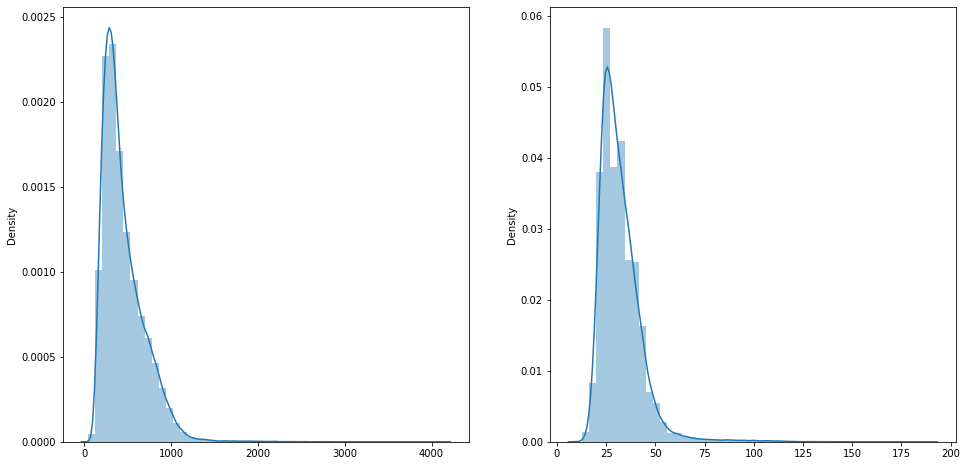

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
sns.distplot([len(hf_tokenizer(df['original'][i]).input_ids) for i in range(len(df))],ax=ax1)
sns.distplot([len(hf_tokenizer(df['summary'][i]).input_ids) for i in range(len(df))],ax=ax2)
# number tokens per sentence.

In [ ]:
org_trunc = [len(hf_tokenizer(df['original'][i]).input_ids) for i in range(len(df))]
print(len([s for s in org_trunc if s > 1024])) # 2333 sentence has tokens > 1024

2333


In [ ]:
org_trunc = [len(hf_tokenizer(df['original'][i]).input_ids) for i in range(len(df))]
print(len([s for s in org_trunc if s > 512])) # 2817 sentence has tokens > 512

33203


In [ ]:
sry_trunc= [len(hf_tokenizer(df['summary'][i]).input_ids) for i in range(len(df))]
print(len([s for s in sry_trunc if s > 64])) # 1538 sentence has tokens > 64

1538


In [ ]:
print(hf_tokenizer), print(hf_config), print(hf_model)

PreTrainedTokenizer(name_or_path='vinai/bartpho-word', vocab_size=64000, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})
MBartConfig {
  "_name_or_path": "vinai/bartpho-word",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "MBartModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "max_position_embeddings": 1024,
  "model

(None, None, None)

In [ ]:
tok_kwargs = {}
if (hf_arch == 'mbart'):
    tok_kwargs['src_lang'], tok_kwargs['tgt_lang'] = "Vi", "Vi"

In [ ]:
before_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                                  max_length=512, max_target_length=128,
                                                  tok_kwargs=tok_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=before_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('original'), 
                   get_y=ColReader('summary'), 
                   splitter=ColSplitter('is_valid'))
# prepare data for train model.

In [ ]:
 dls = dblock.dataloaders(df, bs=8) # create dataloader

In [ ]:
dls.valid_ds[0]

('Toà_án nhân_dân thành_phố Đại_Liên , tỉnh Liêu_Ninh , Trung_Quốc ngày 14-1 kết_án tử_hình với Robert_Lloyd_Schellenberg , công_dân Canada , bị buộc_tội buôn ma_tuý . Vụ_việc lập_tức được liên_kết ngay tới trường_hợp Canada bắt giám_đốc tài_chính Công_ty Huawei_Mạnh_Vãn_Chu , nhiều người nghĩ Trung_Quốc có ý trả_đũa hoặc gây áp_lực ngoại_giao lên Canada để thả bà Mạnh . Thể_diện dân_tộc Vụ Schellenberg thực_chất đã được xử từ năm 2016 , nhưng kết_án đúng thời_điểm nhạy_cảm này . Cũng trong hôm 15-1 , thời_điểm vụ_việc đang nóng , người_phát_ngôn Bộ Ngoại_giao Hoa_Xuân_Oánh khẳng_định Trung_Quốc " bất_bình " với việc Thủ_tướng Canada_Justin_Trudeau nói Bắc_Kinh áp luật_pháp " tuỳ_tiện " trong trường_hợp Schellenberg , đồng_thời lần nữa kêu_gọi Ottawa thả bà Mạnh . Có_thể thấy Trung_Quốc đã " cao_tay " trong vụ Schellenberg . Luật_pháp Trung_Quốc rất nghiêm đối_với ma_tuý , chất cấm , mà bản_thân vấn_đề này cũng sẽ khiến Canada cũng như các nước phương Tây khó chỉ_trích . Tại cuộc họp b

In [ ]:
b = dls.one_batch() # pick one batch
len(b)

2

In [ ]:
b[0]['token_type_ids'].shape

torch.Size([8, 512])

In [ ]:
b[0]['labels'].shape 

torch.Size([8, 55])

In [ ]:
b[0]['input_ids'].shape

torch.Size([8, 512])

In [ ]:
b[1].shape

torch.Size([8, 55])

In [ ]:
dls.valid.show_batch(dataloaders=dls, max_n=2, input_trunc_at=300)

,text,target
0,"<s> Chỉ_thị nêu rõ, để chuẩn_bị tốt các điều_kiện phục_vụ nhân_dân đón năm mới và Tết_Nguyên_đán Kỷ_Hợi vui_tươi, lành_mạnh, an_toàn, tiết_kiệm, Thủ_tướng Chính_phủ yêu_cầu các Bộ_trưởng, Thủ_trưởng cơ_quan ngang Bộ, Thủ_trưởng cơ_quan thuộc Chính_phủ, Chủ_tịch Uỷ_ban_nhân_dân các tỉnh, thành_phố tr","Thủ_tướng Chính_phủ vừa ban_hành Chỉ_thị 34 / CT - TTg về việc tăng_cường các biện_pháp bảo_đảm đón Tết_Nguyên_đán Kỷ_Hợi 2019 vui_tươi, lành_mạnh, an_toàn, tiết_kiệm."
1,"<s> Trong ảnh : thanh_toán viện_phí tại Bệnh_viện Thống_Nhất, TP. HCM - Ảnh : NGUYỄN_CÔNG_THÀNHĐã đến lúc nên nghiên_cứu việc cho khấu_trừ một_số chi_phí hợp_lý trước khi tính thuế TNCN nếu có hoá_đơn như học_phí, tiền thuê nhà... Ông Nguyễn_Thái_SơnTrao đổi với Tuổi_Trẻ, ông Nguyễn_Thái_Sơn nói : -","Đã thoáng với doanh_nghiệp thì cũng nên thoáng với người_dân. Ông Nguyễn_Thái_Sơn, nguyên trưởng_phòng thuế TNCN ( Cục Thuế TP. HCM ) nói như_vậy, và cho_rằng đã đến lúc Luật thuế TNCN cần được điều_chỉnh theo hướng mở hơn."


In [ ]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        }
    }

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(), 
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()
# model 

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

In [ ]:
learn.freeze()

In [ ]:
ob = dls.one_batch()
preds = learn.model(ob[0]) # predict on one batch 

In [ ]:
preds['loss'], preds['logits'].shape, preds['encoder_last_hidden_state'].shape, len(preds['past_key_values']) # check shape of output

(tensor(0.8052, device='cuda:0', grad_fn=<NllLossBackward0>),
 torch.Size([8, 63, 64001]),
 torch.Size([8, 512, 1024]),
 12)

In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(minimum=0.0003019951749593019, steep=3.0199516913853586e-05, valley=4.365158383734524e-05, slide=8.31763736641733e-06)

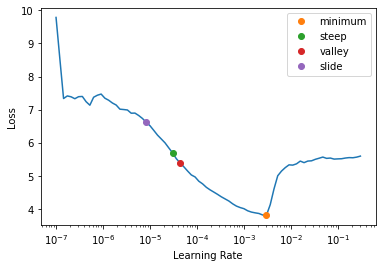

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide]) # find learning rate

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-4, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,1.585326,1.543191,0.516737,0.245488,0.354813,2:29:01
1,1.415166,1.400893,0.526873,0.259323,0.365408,2:29:09
2,1.045875,1.400162,0.528168,0.259853,0.364481,2:29:09


In [ ]:
learn.show_results(learner=learn, input_trunc_at=256, max_n=2)

,text,target,prediction
0,"Chỉ_thị nêu rõ, để chuẩn_bị tốt các điều_kiện phục_vụ nhân_dân đón năm mới và Tết_Nguyên_đán Kỷ_Hợi vui_tươi, lành_mạnh, an_toàn, tiết_kiệm, Thủ_tướng Chính_phủ yêu_cầu các Bộ_trưởng, Thủ_trưởng cơ_quan ngang Bộ, Thủ_trưởng cơ_quan thuộc Chính_phủ, Chủ_tịc","Thủ_tướng Chính_phủ vừa ban_hành Chỉ_thị 34 / CT - TTg về việc tăng_cường các biện_pháp bảo_đảm đón Tết_Nguyên_đán Kỷ_Hợi 2019 vui_tươi, lành_mạnh, an_toàn, tiết_kiệm.",Thủ_tướng Chính_phủ vừa ban_hành Chỉ_thị số 34 / CT - TTg về tăng_cường các biện_pháp bảo_đảm cung_ứng
1,"Thông_tin này được ông Trương_Văn_Phước, quyền Chủ_tịch Uỷ_ban Giám_sát Tài_chính quốc_gia ( NFSC ) đưa ra tại báo_cáo Tổng_quan thị_trường tài_chính Việt_Nam 2018 diễn ra tại Hà_Nội ngày 20/12. Như_vậy, mức tăng_trưởng này cao hơn hẳn so với chỉ_tiêu đặt","Theo báo_cáo của Uỷ_ban Giám_sát Tài_chính Quốc_gia, ước_tính tăng_trưởng kinh_tế GDP cả năm 2018 của Việt_Nam đạt 6,9-7 %, cao nhất trong 10 năm trở_lại đây.","Năm 2018 , tốc_độ tăng_trưởng GDP của Việt_Nam đạt 6,7 % , cao hơn mức trung_bình thế_giới"


# Inference

In [ ]:
test_df['original'][0]

'Một tiêm_kích F -15 K của Hàn_Quốc . Lực_lượng cứu_hộ Hàn_Quốc được điều tới ngọn núi gần thị_trấn Chilgok , cách thủ_đô Seoul 300 km về phía đông nam , sau khi nhận được tin một chiếc tiêm_kích gặp nạn tại đây , theo Yonhap . Không_quân Hàn_Quốc xác_nhận một tiêm_kích F -15 K của họ đã đâm vào núi , nhưng chưa rõ nguyên_nhân gặp nạn cũng như số_phận của hai phi_công trên máy_bay . Một nhân_chứng gần đó cho_biết đã nghe thấy một loạt tiếng nổ làm rung_chuyển toà nhà . Quan_chức giấu tên của Sở Cứu_hoả Chilgok nói rằng lực_lượng cứu_hộ chưa nhìn thấy máy_bay rơi và đang đi bộ để tiếp_cận hiện_trường do địa_hình hiểm_trở . Tiêm_kích F -15 K Slam_Eagle được hãng Boeing phối_hợp với các công_ty Hàn_Quốc sản_xuất dành riêng cho không_quân nước này . Được phát_triển từ tiêm_kích đa_năng F -15 E Strike_Eagle của Mỹ , F -15 K được trang_bị nhiều hệ_thống tác_chiến_điện_tử và cảm_biến tối_tân , cùng các tên_lửa hành_trình chuyên phá hầm ngầm . Nguyễn_Hoàng   Một tiêm_kích F -15 K của Hàn_Quốc 

In [ ]:
outputs = learn.blurr_generate(test_df['original'][0])

print(f'=== Prediction ===\n{outputs[0]}\n')

=== Prediction ===
Một chiếc tiêm_kích F -15 K của không_quân Hàn_Quốc hôm_nay gặp nạn tại một ngọn núi gần



# Save model

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

ERROR:root:HfApi.login: This method is deprecated in favor of `set_access_token`.


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
!sudo apt-get install git-lfs -qq

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.3.4-1_amd64.deb ...
Unpacking git-lfs (2.3.4-1) ...
Setting up git-lfs (2.3.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!git config --global user.email "haotieu1601@gmail.com"
!git config --global user.name "haotieu"

In [ ]:
from blurr.data.core import get_blurr_tfm
blurr_tfm = get_blurr_tfm(learn.dls.before_batch)

In [ ]:
blurr_tfm.hf_model.push_to_hub("vietnamese-summarization",use_temp_dir=True)

In [ ]:
blurr_tfm.hf_tokenizer.push_to_hub("vietnamese-summarization",use_temp_dir=True)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:1004: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/haotieu/vietnamese-summarization into local empty directory.


Download file pytorch_model.bin:   0%|          | 9.90k/1.57G [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.57G [00:00<?, ?B/s]

To https://huggingface.co/haotieu/vietnamese-summarization
   85858b9..b329533  main -> main

   85858b9..b329533  main -> main



'https://huggingface.co/haotieu/vietnamese-summarization/commit/b32953342cc67c7b07a2706398d670b0add8a2af'